# Minimum Viable Product (resubmission)

## Classify Handwritten Numbers

### MVP Overview
- **Goal:** To create a method to classify handwritten numbers. The client known as FakeBank has a need to start classifying numbers which have been handwritten in various types of handwriting. This will enable the bank to start a basic neural network of recognizing digits 0-9 first, which can then be transferred to learning larger numbers commonly written on checks.
- **Solution Path:** The data chosen to being used is from the MNIST dataset and a jpeg containing a handwritten integer.
  - data -- per the download [page](https://huggingface.co/datasets/mnist) a 70,000 28x28 black-and-white images - 60,000 images in the training dataset and 10,000 images in the validation dataset, one class per digit so a total of 10 classes, with 7,000 images (6,000 train images and 1,000 test images) per class. Half of the image were drawn by Census Bureau employees and the other half by high school students (this split is evenly distributed in the training and testing sets).
  - labels -- an integer between 0 and 9 representing the digit.
- **Work Completed**: As this is a resubmission of the original MVP, I had to mostly start over as the previous MVP was for a different use case. The reason why this was chosen instead was due to the datasets needed to complete the project were all privaye and despite the requests for content, the dataset owners did not respond. As such, I have completed most of the code. I first accessed the MNIST dataset from the Keras dataset library. From there, I converted the classes to categorical class matrices, ensured the data was parsed as floats, created some initial metrics like shapes, and plotted 25 random images from the dataset. I then put each task into its own section which follows the lesson taught in [Introduction to Neural Networks](https://app.thisismetis.com/courses/222/pages/home-introduction-to-neural-networks). I created a baseline logistic regression model and got the accuracy score, created a CNN model using Keras, performed inference on the test set as well as a completely separate image I made from writing a number down, taking the picture, uploading it to a directory, then importing and converting the image to the needed formats for model inference.
- **Recent Findings:** The model summary stated the existing model has 206,922 trainable parameters. The basline accuracy from the logistic regression was 0.8972 to where after 20 epochs the validation accuracy score of the CNN is 0.9907.
- **Moving Forward:** I will attempt a transfer learning model for having it for the client to use for training higher numbered models.

### Steps to Code a Neural Network

1. Build network structure
2. Complile the model (loss function, metrics, and optimizer)
3. Fit model on training data (batch size, number of epochs)
4. Make predictions for new data
5. Evaluate results

#### References
- https://app.thisismetis.com/courses/222/pages/chapter-10-keras?module_item_id=12549
- https://www.tensorflow.org/datasets/keras_example
- https://www.analyticsvidhya.com/blog/2021/06/mnist-dataset-prediction-using-keras/
- https://datascience.stackexchange.com/questions/46885/how-to-reshape-xtrain-array-and-what-about-input-shape
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar100/load_data
- https://www.kaggle.com/code/leokaka/cnn-66-acc-on-cifar100-without-transfer-learning
- https://www.kaggle.com/code/jsrshivam/mnist-digit-recognition-nn/notebook
- https://github.com/keras-team/keras
- https://towardsdatascience.com/cifar-100-pre-processing-for-image-recognition-task-68015b43d658
- https://olaralex.com/cnn-on-cifar100/
- https://stackoverflow.com/questions/66190989/input-0-of-layer-sequential-is-incompatible-with-the-layer-expected-axis-1-of
- https://www.tensorflow.org/guide/keras/train_and_evaluate/
- https://github.com/chetnakhanna16/CIFAR100_ImageRecognition
- https://github.com/andrewkruger/tensorflow_tutorials/blob/master/cnn.ipynb
- https://in2techs.com/mnist-classification-using-logistic-regression-classifier-in-python/?doing_wp_cron=1667074980.2064399719238281250000
- https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
- https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-convnet-for-cifar-10-and-cifar-100-classification-with-keras.md
- https://github.com/andrewkruger/cifar100_CNN
- https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100

### Imports

In [1]:
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

from sklearn import datasets, metrics, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

### EDA

#### Load MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
mnist = datasets.load_digits()
images = mnist.images
labels = mnist.target
data_size = len(images)

In [3]:
# shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"shape of first image (X_train[0]): {X_train[0].shape}")

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of samples in dataset
print(f"\ntrain samples: {X_train.shape[0]}")
print(f"test samples: {X_test.shape[0]}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
shape of first image (X_train[0]): (28, 28)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)

train samples: 60000
test samples: 10000


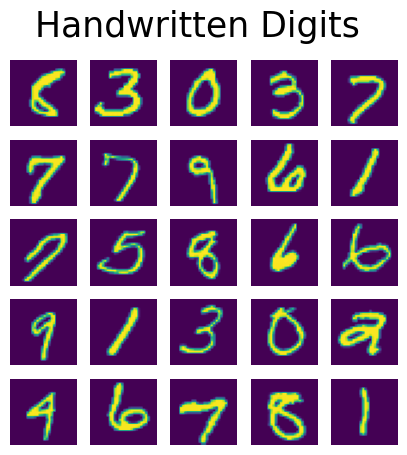

In [4]:
# set figure size
rcParams['figure.figsize'] = 5,5

# number of columns and rows in which images needs to be displayed
num_row = 5
num_col = 5

# to get 4 * 4 = 16 images together
pic_id = np.random.randint(0, len(X_train), num_row * num_col)

# create subplots
fig, axes = plt.subplots(num_row, num_col)

# title
plt.suptitle('Handwritten Digits', fontsize=25)

# subplots
for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i * num_col) + j
        axes[i,j].imshow(X_train[pic_id[k]])
        # switch off x/y axis labels
        axes[i,j].axis('off')

### Build network structure

In [5]:
# define number of classes
num_classes = 10

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# parse numbers as floats which will speed up training
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize data into the [latex][-1, 1][/latex] range
X_train /= 255.
X_test /= 255.

#### Baseline logistic regression

In [6]:
# preprocess
images = images.reshape(len(images), -1)
images = preprocessing.scale(images)

# train test split
split = 0.80
X_train_lr, y_train_lr = images[:int(data_size * split)], labels[:int(data_size * split)]
X_test_lr, y_test_lr = images[int(data_size * split):], labels[int(data_size * split):]

# initialize model
lr = LogisticRegression()

# train the lr on X_train, y_train
lr.fit(X_train_lr, y_train_lr)

# make predictions
predictions = lr.predict(X_test_lr)

print(f"baseline accuracy score: {metrics.accuracy_score(y_test_lr, predictions)}")

baseline accuracy score: 0.8972222222222223


#### CNN model

In [7]:
# reshape for keras
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [8]:
def get_uncompiled_model():

    model = Sequential()

    # 2 convolutional layers with 16 units
    model.add(Conv2D(16, kernel_size=3, input_shape=(28,28,1), padding='same', activation="relu"))

    # pooling - look at the grid (2x2) and use max only
    # removes the number of parameters used and leaves most significant to prevent overfitting and reduces memory
    model.add(MaxPooling2D())
    model.add(Conv2D(32, kernel_size=3, padding='same', activation="relu"))
    model.add(MaxPooling2D())    

    # from the reference from Andrew Kruger, PhD as included in the reference section:
    # The neural network ultimately needs to output the probability of the different classes in an array. 
    # After the convolution stacks, the probabilities need to be flattened to a 1D feature vector. 
    # The dense layers are fully-connected layers that apply transformations and change the dimensions. 
    # The final dense layer needs to be the same length as the number of classes, and gives the probability of each class.

    # post convolutional stacks
    # flatten to a 1d vector
    model.add(Flatten())

    # add the dense layer - 128 units
    model.add(Dense(128))
    model.add(Activation('relu'))
    # if overfit, uncomment
    #model.add(Dropout(0.2))

    # add the final dense layer
    num_classes = 10
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

### Compile the model

In [9]:
# initiate optimizer choice and train

def get_compiled_model():
    
    model = get_uncompiled_model()
    opt = Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy',
                    optimizer=opt, 
                    metrics=['accuracy'])

    return model

In [10]:
# show summary stats
model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               200832    
_________________________________________________________________
activation (Activation)      (None, 128)               0

2022-10-29 17:37:37.414311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-29 17:37:37.414496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fit the model to training data

In [11]:
history = model.fit(
                X_train, 
                y_train, 
                epochs=10, 
                batch_size=16, 
                validation_data=(X_test, y_test)
)

2022-10-29 17:37:37.576104: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.2727 - accuracy: 0.9175 - val_loss: 0.0424 - val_accuracy: 0.9867
Epoch 2/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0416 - accuracy: 0.9871 - val_loss: 0.0402 - val_accuracy: 0.9872
Epoch 3/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.0403 - val_accuracy: 0.9872
Epoch 4/10
3750/3750 [==============================] - 17s 4ms/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0287 - val_accuracy: 0.9906
Epoch 5/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.0366 - val_accuracy: 0.9896
Epoch 6/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0382 - val_accuracy: 0.9890
Epoch 7/10
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0313 - val_ac

### Make predictions for new data

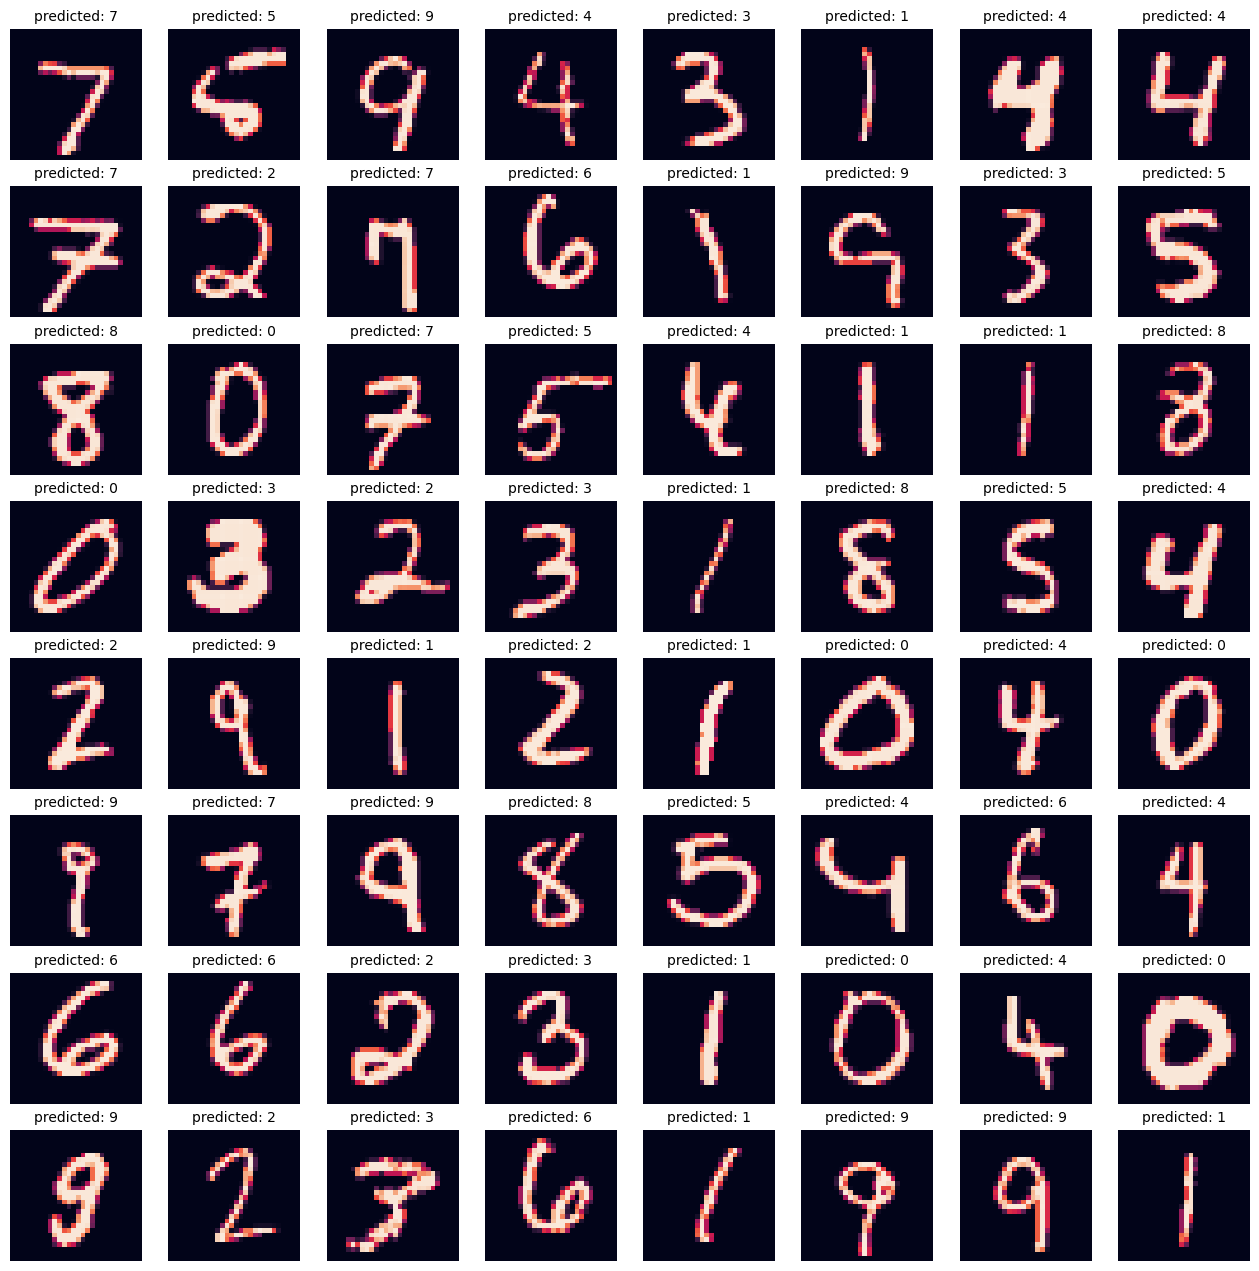

In [12]:
predictions = model.predict(X_test, batch_size=None, verbose=0, steps=None)
predictions = np.argmax(predictions, axis=1)

idx = 0
f, axarr = plt.subplots(8, 8, figsize=(16,16))

for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(np.squeeze(X_test[idx]), cmap='rocket')
        axarr[i,j].set_title("predicted: " + str(predictions[idx]),fontsize=10)
        axarr[i,j].axis('off')
        idx += 8

##### Handwritten and Uploaded

image shape: (1, 28, 28, 1)


/Users/randy.grant/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


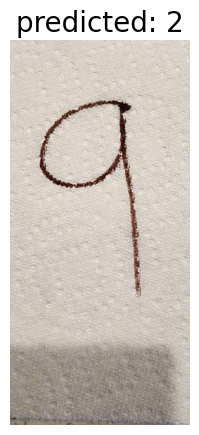

In [13]:
def input_prepare(img):
    img = np.asarray(img)
    img = cv2.resize(img, (28, 28))
    img = img / 255
    img = img.reshape(1,28,28,1)
    return img 

img = cv2.imread('./images/handwritten.jpeg')
orig = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = input_prepare(img)
print(f"image shape: {img.shape}")


pred = model.predict(img)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title(np.argmax(pred, axis=1))
plt.title("predicted: " + str(predictions[idx]),fontsize=20)
plt.axis('off')

plt.show();

### Evaluate results

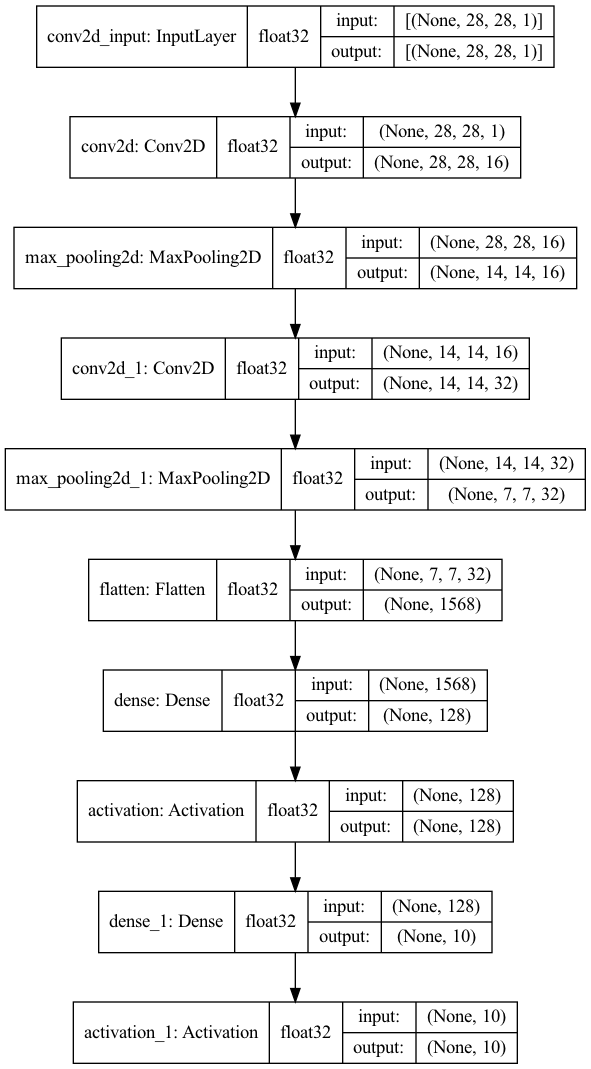

In [14]:
keras.utils.plot_model(
    model,
    to_file='model-details.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

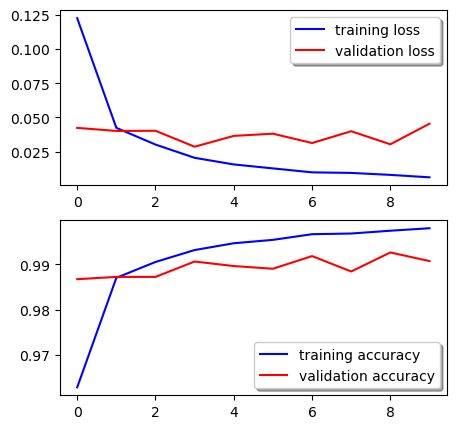

In [15]:
# plot loss and accuracy
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

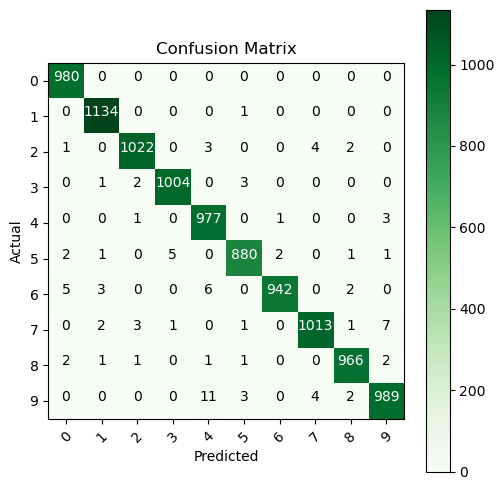

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10)) 